<a href="https://www.kaggle.com/code/mehmetcantemir1/first?scriptVersionId=214187274" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
# Veri setinin bulunduğu klasör yolu
data_dir = "/kaggle/input/augmented-skin-conditions-image-dataset/Skin_Conditions"

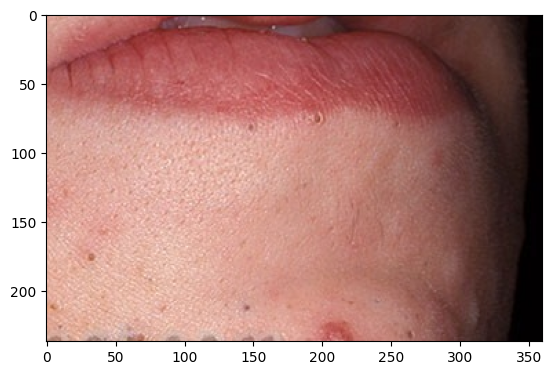

In [2]:
# Örnek bir görüntüyü yükleyin ve gösterin
example_image_path = os.path.join(data_dir, "Acne", "Acne_1.jpg")
example_image = Image.open(example_image_path)
plt.imshow(example_image)

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_size = (224, 224)

# Veri arttırımı ve ön işleme için ImageDataGenerator kullanımı
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3, 
    shear_range=0.3,
    zoom_range=0.3, 
    horizontal_flip=True,
    brightness_range=[0.2,1.5],
    validation_split=0.2 )

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)





Found 1920 images belonging to 6 classes.
Found 474 images belonging to 6 classes.


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


60/60 ━━━━━━━━━━━━━━━━━━━━ 915s 14s/step - accuracy: 0.1932 - loss: 2.3403 - val_accuracy: 0.1688 - val_loss: 2.2452
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 858s 14s/step - accuracy: 0.3569 - loss: 1.7965 - val_accuracy: 0.1667 - val_loss: 2.1945
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 847s 14s/step - accuracy: 0.5113 - loss: 1.4160 - val_accuracy: 0.1667 - val_loss: 2.4020
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 856s 14s/step - accuracy: 0.6159 - loss: 1.1809 - val_accuracy: 0.1667 - val_loss: 2.3094
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 876s 14s/step - accuracy: 0.6951 - loss: 0.9919 - val_accuracy: 0.1667 - val_loss: 2.3577
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 903s 14s/step - accuracy: 0.7218 - loss: 0.8820 - val_accuracy: 0.1477 - val_loss: 2.4763
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 854s 14s/step - accuracy: 0.7462 - loss: 0.8291 - val_accuracy: 0.1561 - val_loss: 2.3650
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 849s 14s/step - accuracy: 0.7951 - loss: 0.7095 - val_accuracy: 0.1835 - val_

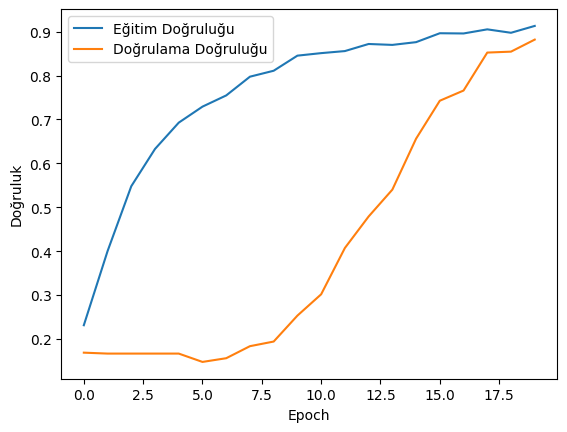

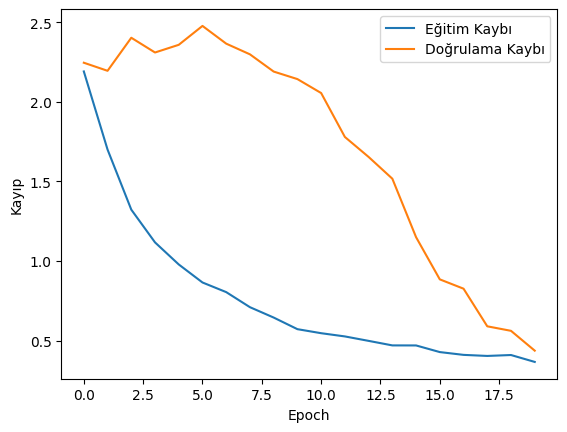

In [4]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# ResNet50 modelini yükleyin ve son katmanı dahil edin
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))



from tensorflow.keras.layers import Dropout # Özellik çıkarımı için GlobalAveragePooling2D katmanı ekleyin
x = base_model.output
x = GlobalAveragePooling2D()(x)
# Dropout katmanı ekleyin
x = Dropout(0.5)(x)

# Yeni sınıflandırma katmanlarını ekleyin, L2 düzenlemesi ile
from tensorflow.keras.regularizers import l2

predictions = Dense(6, activation='softmax', kernel_regularizer=l2(0.01))(x)


# Modeli tanımlayın
model = Model(inputs=base_model.input, outputs=predictions)

# İlk katmanları dondurun ve sadece son katmanları eğitin
for layer in base_model.layers:
    layer.trainable = True


from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# Erken durdurma ve model kontrol noktası
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss') # Modeli eğitin history = model.fit(train_generator, validation_data=validation_generator, epochs=50, callbacks=[early_stopping, model_checkpoint])

# Modeli derleyin
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

# Modeli eğitin
history = model.fit(train_generator, validation_data=validation_generator, epochs=20, callbacks=[early_stopping, model_checkpoint])



# Eğitim ve doğrulama kayıplarını ve doğruluklarını görselleştirin
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.show()




15/15 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step


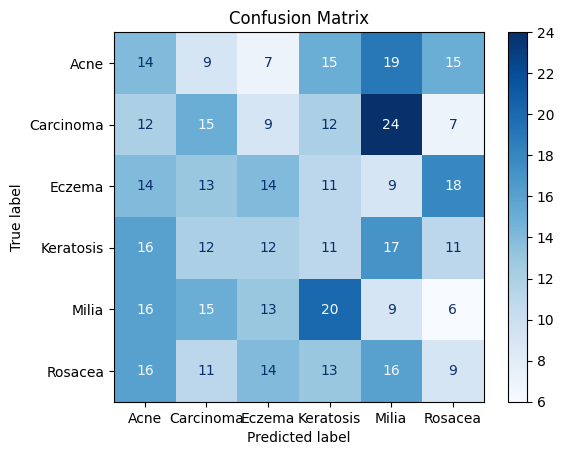

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Doğrulama setinden tahminler al
val_predictions = model.predict(validation_generator)
val_predictions_classes = np.argmax(val_predictions, axis=1)  # Sınıf tahminleri

# Gerçek sınıfları al
true_classes = validation_generator.classes

# Confusion matrix oluştur
conf_matrix = confusion_matrix(true_classes, val_predictions_classes)

# Confusion matrix'i görselleştir
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=validation_generator.class_indices.keys())
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()


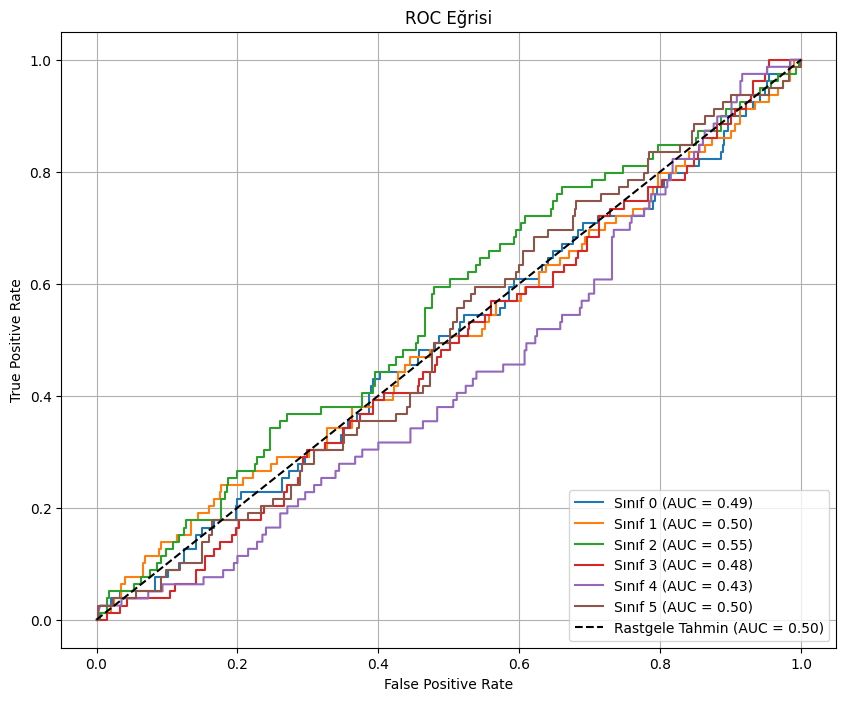

In [6]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Gerçek etiketleri one-hot encode yap
n_classes = len(validation_generator.class_indices)
true_classes_one_hot = label_binarize(true_classes, classes=range(n_classes))

# ROC eğrisi için FPR, TPR değerlerini hesapla
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_classes_one_hot[:, i], val_predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Tüm sınıflar için ROC eğrisini çiz
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Sınıf {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Rastgele Tahmin (AUC = 0.50)")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Eğrisi')
plt.legend(loc='lower right')
plt.grid()
plt.show()
